# Proof of concept - Splitting Landsat-2 Tiles (Leman)

In [1]:
import rasterio
from rasterio.plot import show
from rasterio.windows import Window, bounds, from_bounds 
from rasterio.transform import rowcol, xy
import glob
import os

import matplotlib.pyplot as plt
import json
from pyproj import Transformer
from shapely.geometry import Polygon

from sentinelhub import BBox, CRS

In [2]:
# File and folder paths
dirpath = r"data\sentinel2"
search_criteria = "*\\R10m\\transformed_tci.jp2"
q = os.path.join(dirpath, search_criteria)
print(q)

data\sentinel2\*\R10m\transformed_tci.jp2


In [3]:
filenames = glob.glob(q)
filenames

['data\\sentinel2\\31TGM,2021-02-23,0\\R10m\\transformed_tci.jp2',
 'data\\sentinel2\\32TLS,2021-02-23,0\\R10m\\transformed_tci.jp2']

In [4]:
files = []

In [5]:
for filename in filenames:
    file = rasterio.open(filename)
    files.append(file)

In [6]:
files

[<open DatasetReader name='data\sentinel2\31TGM,2021-02-23,0\R10m\transformed_tci.jp2' mode='r'>,
 <open DatasetReader name='data\sentinel2\32TLS,2021-02-23,0\R10m\transformed_tci.jp2' mode='r'>]

In [7]:
def window_in_bounds(window, bounds):
    w_left, w_bottom, w_right, w_top = window
    b_left, b_bottom, b_right, b_top = bounds
    
    in_horizontal = w_left > b_left and w_right < b_right
    in_vertical = w_bottom > b_bottom and w_top < b_top
    
    return in_horizontal and in_vertical

In [8]:
def show_polygon(polygon, label=''):
    plt.plot(*polygon.exterior.xy, label=label)
    
    if label != '':
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
def metadata_polygon(jsonPath):
    data = json.load(open(jsonPath))    

    crs_name = data["tileGeometry"]["crs"]["properties"]["name"].split(':')[-3]
    crs_number = data["tileGeometry"]["crs"]["properties"]["name"].split(':')[-1]

    coordinates = data["tileGeometry"]["coordinates"][0]
    transformer = Transformer.from_crs(f'{crs_name}:{crs_number}', "epsg:4326")
    coordinates = [list(transformer.transform(point[0], point[1])) for point in coordinates]
    coordinates = [[point[1], point[0]] for point in coordinates]

    return Polygon(coordinates)
    
def inner_bbox(polygon):
    x, y = polygon.exterior.coords.xy
    # sort coords and remove duplicate
    x = sorted(x[:-1])
    y = sorted(y[:-1])
    
    min_x, max_x = x[1], x[2]
    min_y, max_y = y[1], y[2]
    
    polygon = ((min_x, min_y),
               (min_x, max_y),
               (max_x, max_y),
               (max_x, min_y))
    
    return BBox(bbox=[(min_x, min_y), (max_x, max_y)], crs=CRS.WGS84)

def inner_bounds_from_metadata(metadata):
    data = json.load(open(metadata))    

    crs_name = data["tileGeometry"]["crs"]["properties"]["name"].split(':')[-3]
    crs_number = data["tileGeometry"]["crs"]["properties"]["name"].split(':')[-1]

    coordinates = data["tileGeometry"]["coordinates"][0]
    transformer = Transformer.from_crs(f'{crs_name}:{crs_number}', "epsg:4326")
    coordinates = [list(transformer.transform(point[0], point[1])) for point in coordinates]
    coordinates = [[point[1], point[0]] for point in coordinates]

    polygon = Polygon(coordinates)
    
    x, y = polygon.exterior.coords.xy
    # sort coords and remove duplicate
    x = sorted(x[:-1])
    y = sorted(y[:-1])
    
    min_x, max_x = x[1], x[2]
    min_y, max_y = y[1], y[2]
    
    return (min_x, min_y, max_x, max_y)

# Example showing windows

Window in bounds       : data\sentinel2\31TGM,2021-02-23,0\R10m\transformed_tci.jp2
Window (px)            : (7006.0, 4735.0, 6006.0, 5735.0)
Window (calc) (wsg84)  : (6.100922728978585, 46.15203205364772, 6.211040620106256, 46.262149944775395)
Window (true) (wsg84)  : (6.100922728978585, 46.15203205364772, 6.211040620106255, 46.262149944775395)


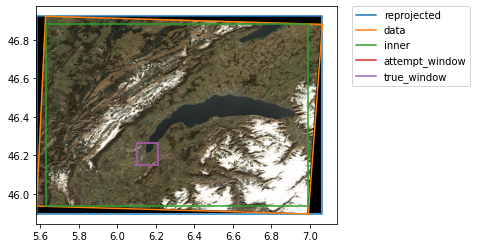

In [12]:
center_of_window = (6.1558778,46.2071949) # jet d'eau de genève
#center_of_window = (5.6044984,46.0038049) # point blanc hors du "inner" bbox (ne devrait pas être exporté)
window_size = 1000

input_filename = 'data\\sentinel2\\31TGM,2021-02-23,0\\R10m\\transformed_tci.jp2'
metadata_filename = 'data\\sentinel2\\31TGM,2021-02-23,0\\tileInfo.json'
preview_filename = 'data\\sentinel2\\31TGM,2021-02-23,0\\preview.png'
output_filename = 'data\\sentinel2\\splits\\example.png'

with rasterio.open(input_filename, 'r') as file:    
    file_transform = file.transform
    # center of window (pixels)
    x, y = rowcol(file_transform, center_of_window[0], center_of_window[1], round)
    
    # bound limits (pixels)
    left_px, bottom_py = x + window_size/2, y - window_size/2
    right_px, top_py =   x - window_size/2, y + window_size/2
    # bound limits (wgs84)
    left, bottom = xy(file_transform, left_px, bottom_py, offset='center')
    right, top = xy(file_transform, right_px, top_py, offset='center')    
    # bounds (wgs84)
    calc_bounds = (left, bottom, right, top)
    
    inner_bounds = inner_bounds_from_metadata(metadata_filename)

    if window_in_bounds(calc_bounds, inner_bounds):
        # Create a Window and calculate the transform from the source dataset
        window = from_bounds(left, bottom, right, top, file_transform)
        window_transform = file.window_transform(window)
        window_bounds = bounds(window, file_transform)

        print(f'Window in bounds       : {file.name}')
        print(f'Window (px)            : {(left_px, bottom_py, right_px, top_py)}')
        print(f'Window (calc) (wsg84)  : {calc_bounds}')
        print(f'Window (true) (wsg84)  : {window_bounds}')

        attempted_window_bbox = BBox(bbox=[(left, bottom), (right, top)], crs=CRS.WGS84)
        true_window_bbox = BBox(bbox=[(window_bounds[0], window_bounds[1]), (window_bounds[2], window_bounds[3])], crs=CRS.WGS84)

        transformed_bbox = BBox(bbox=[(file.bounds[0], file.bounds[1]), (file.bounds[2], file.bounds[3])], crs=CRS.WGS84)
        metadata_poly = metadata_polygon(metadata_filename)
        inner_box = inner_bbox(metadata_poly)

        image = plt.imread(preview_filename)
        plt.imshow(image, extent=[5.579, 7.06, 45.9, 46.92])

        show_polygon(transformed_bbox.geometry,      label='reprojected')
        show_polygon(metadata_poly,                  label='data')
        show_polygon(inner_box.geometry,             label='inner')
        show_polygon(attempted_window_bbox.geometry, label='attempt_window')
        show_polygon(true_window_bbox.geometry,      label='true_window')

        # Create a new cropped raster to write to
        profile = file.profile
        profile.update({
            'driver': 'PNG',
            'height': window_size,
            'width': window_size,
            'transform': window_transform})

        with rasterio.open(output_filename, 'w', **profile) as dst:
            # Read the data from the window and write it to the output image
            dst.write(file.read(window=window))